# SAS Viya Python Client Demo: A Simple Pipeline Using Decision Tree to Analyze Survival Data From the Titanic

## Import packages:   SAS Wrapper for Analytic Transfer and Opensource Libraries

In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from swat import *

## Connect to CAS with the port number

In [4]:
s = CAS('centis', 5570,'sasdemo', 'SASpw123')
print(s);

CAS('centis', 5570, 'sasdemo', protocol='cas', name='py-session-1', session='b7c69add-4d59-f242-a6be-a9fe099e8d51')


In [5]:
s.loadactionset(actionset="dataStep")

NOTE: Added action set 'dataStep'.


[actionset]

 'dataStep'

+ Elapsed: 0.00065s, sys: 0.000764s, mem: 0.0468mb

## Ask for CAS server status

In [6]:
s.builtins.serverStatus()

NOTE: Grid node action status report: 1 nodes, 9 total actions executed.


[About]

 {'CAS': 'Cloud Analytic Services',
  'Copyright': 'Copyright © 2014-2016 SAS Institute Inc. All Rights Reserved.',
  'System': {'Hostname': 'centis',
   'Model Number': 'x86_64',
   'OS Family': 'LIN X64',
   'OS Name': 'Linux',
   'OS Release': '3.10.0-514.6.1.el7.x86_64',
   'OS Version': '#1 SMP Wed Jan 18 13:06:36 UTC 2017'},
  'Version': '3.01',
  'VersionLong': 'V.03.01M0P09072016',
  'license': {'expires': '24. Oktober 2017 00.00 Uhr',
   'gracePeriod': 45,
   'maxCPUs': 9999,
   'site': 'E25675: Test Viya3.1',
   'siteNum': 70068118,
   'warningPeriod': 55}}

[server]

 Serverstatus
 
    nodes  actions
 0      1        9

[nodestatus]

 Knotenstatus
 
                    name        role  uptime  running  stalled
 0  centis.example.local  controller   3.005        0        0

+ Elapsed: 0.000735s, sys: 0.000787s, mem: 0.0617mb

In [7]:
s.invoke('echo', a=[1, 2, 3], b={'one':'x', 'two':'y', 'three':'z'})

CAS('centis', 5570, 'sasdemo', protocol='cas', name='py-session-1', session='b7c69add-4d59-f242-a6be-a9fe099e8d51')

## Load the decision tree action set

In [8]:
s.loadactionset('decisionTree')

NOTE: Added action set 'decisionTree'.


[actionset]

 'decisionTree'

+ Elapsed: 0.00155s, user: 0.000105s, sys: 0.00133s, mem: 0.0307mb

In [9]:
s.tableinfo()

NOTE: No tables are available in caslib CASUSER(sasdemo) of Cloud Analytic Services.


+ Elapsed: 0.000347s, user: 7.4e-05s, sys: 0.000217s, mem: 0.0394mb

## Load data sets from Amazon S3 into CAS

In [10]:
out = s.upload("http://s3.amazonaws.com/assets.datacamp.com/course/Kaggle/train.csv",
               casout=dict(name='train',replace = True))
out = s.upload("http://s3.amazonaws.com/assets.datacamp.com/course/Kaggle/test.csv",
               casout=dict(name='test',replace = True))

NOTE: Cloud Analytic Services made the uploaded file available as table TRAIN in caslib CASUSER(sasdemo).
NOTE: The table TRAIN has been created in caslib CASUSER(sasdemo) from binary data uploaded to Cloud Analytic Services.
NOTE: Cloud Analytic Services made the uploaded file available as table TEST in caslib CASUSER(sasdemo).
NOTE: The table TEST has been created in caslib CASUSER(sasdemo) from binary data uploaded to Cloud Analytic Services.


In [11]:
out = s.upload("TitanicTrain.csv",
               casout=dict(name='train', replace=True))
out = s.upload("TitanicTest.csv",
               casout=dict(name='test', replace=True))

NOTE: Cloud Analytic Services made the uploaded file available as table TRAIN in caslib CASUSER(sasdemo).
NOTE: The table TRAIN has been created in caslib CASUSER(sasdemo) from binary data uploaded to Cloud Analytic Services.
NOTE: Cloud Analytic Services made the uploaded file available as table TEST in caslib CASUSER(sasdemo).
NOTE: The table TEST has been created in caslib CASUSER(sasdemo) from binary data uploaded to Cloud Analytic Services.


In [12]:
s.tableinfo()

,Name,Rows,Columns,Encoding,CreateTimeFormatted,ModTimeFormatted,JavaCharSet,CreateTime,ModTime,Global,Repeated,View,SourceName,SourceCaslib,Compressed,Creator,Modifier
0,TRAIN,891,12,utf-8,18. Februar 2017 22.47 Uhr,18. Februar 2017 22.47 Uhr,UTF8,1.803077e+09,1.803077e+09,0,0,0,,,0,sasdemo,
1,TEST,418,11,utf-8,18. Februar 2017 22.47 Uhr,18. Februar 2017 22.47 Uhr,UTF8,1.803077e+09,1.803077e+09,0,0,0,,,0,sasdemo,


## Create an Instace of Cas Table Object

In [13]:
dtrain = s.CASTable("TRAIN")
dtest = s.CASTable("TEST")

## Data Exploration

### 1. Get to know your data (what is target? what are variables?)

In [14]:
dtrain.columninfo()

,Column,ID,Type,RawLength,FormattedLength,NFL,NFD
0,PassengerId,1,double,8,12,0,0
1,Survived,2,double,8,12,0,0
2,Pclass,3,double,8,12,0,0
3,Name,4,varchar,82,82,0,0
4,Sex,5,varchar,6,6,0,0
5,Age,6,double,8,12,0,0
6,SibSp,7,double,8,12,0,0
7,Parch,8,double,8,12,0,0
8,Ticket,9,varchar,18,18,0,0
9,Fare,10,double,8,12,0,0


In [15]:
dtrain.fetch(to=10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1.0,0.0,3.0,"Braund, Mr. Owen Harris",male,22.0,1.0,0.0,A/5 21171,725.0,,S
1,2.0,1.0,1.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1.0,0.0,PC 17599,712833.0,C85,C
2,3.0,1.0,3.0,"Heikkinen, Miss. Laina",female,26.0,0.0,0.0,STON/O2. 3101282,7925.0,,S
3,4.0,1.0,1.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1.0,0.0,113803,531.0,C123,S
4,5.0,0.0,3.0,"Allen, Mr. William Henry",male,35.0,0.0,0.0,373450,805.0,,S
5,6.0,0.0,3.0,"Moran, Mr. James",male,NaN,0.0,0.0,330877,84583.0,,Q
6,7.0,0.0,1.0,"McCarthy, Mr. Timothy J",male,54.0,0.0,0.0,17463,518625.0,E46,S
7,8.0,0.0,3.0,"Palsson, Master. Gosta Leonard",male,2.0,3.0,1.0,349909,21075.0,,S
8,9.0,1.0,3.0,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0.0,2.0,347742,111333.0,,S
9,10.0,1.0,2.0,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1.0,0.0,237736,300708.0,,C


In [16]:
dtrain.distinct()

,Column,NDistinct,NMiss,Trunc
0,PassengerId,891.0,0.0,0.0
1,Survived,2.0,0.0,0.0
2,Pclass,3.0,0.0,0.0
3,Name,891.0,0.0,0.0
4,Sex,2.0,0.0,0.0
5,Age,88.0,177.0,0.0
6,SibSp,7.0,0.0,0.0
7,Parch,7.0,0.0,0.0
8,Ticket,681.0,0.0,0.0
9,Fare,246.0,0.0,0.0


In [17]:
outSumm = dtrain.summary()
outSumm

,Column,Min,Max,N,NMiss,Mean,Sum,Std,StdErr,Var,USS,CSS,CV,TValue,ProbT
0,PassengerId,1.0,891.0,891.0,0.0,446.000000,397386.0,257.353842,8.621678,6.623100e+04,2.361797e+08,5.894559e+07,57.702655,51.730069,1.766713e-270
1,Survived,0.0,1.0,891.0,0.0,0.383838,342.0,0.486592,0.016301,2.367722e-01,3.420000e+02,2.107273e+02,126.770139,23.546257,1.117856e-95
2,Pclass,1.0,3.0,891.0,0.0,2.308642,2057.0,0.836071,0.028009,6.990151e-01,5.371000e+03,6.221235e+02,36.214851,82.423709,0.000000e+00
3,Age,1.0,705.0,714.0,177.0,38.420168,27432.0,56.525211,2.115403,3.195100e+03,3.332048e+06,2.278106e+06,147.123800,18.162105,7.119159e-61
4,SibSp,0.0,8.0,891.0,0.0,0.523008,466.0,1.102743,0.036943,1.216043e+00,1.326000e+03,1.082278e+03,210.846437,14.157044,3.481639e-41
5,Parch,0.0,6.0,891.0,0.0,0.381594,340.0,0.806057,0.027004,6.497282e-01,7.080000e+02,5.782581e+02,211.234407,14.131042,4.707998e-41
6,Fare,0.0,5123292.0,891.0,0.0,127660.655443,113745644.0,411122.992611,13773.138477,1.690221e+11,1.649505e+14,1.504297e+14,322.043617,9.268814,1.383327e-19


### 2. Gender vs Survived

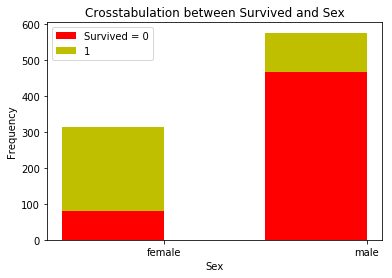

In [18]:
xtab_out = dtrain.crosstab(row = "Survived", col = "Sex")
survived0=xtab_out["Crosstab"].loc[0][1:3]
survived1=xtab_out["Crosstab"].loc[1][1:3]
ind = np.arange(2)    # the x locations for the groups
width = 0.5       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, survived0, width, color='r')
p2 = plt.bar(ind, survived1, width, color='y', bottom=survived0)

plt.ylabel('Frequency')
plt.xlabel('Sex')
plt.title('Crosstabulation between Survived and Sex')
plt.xticks(ind + width/2., ('female', 'male'))
plt.legend((p1[0], p2[0]), ('Survived = 0', '1'), loc=2)

*__Survival rate of women is much higher than that of men. Good job gentlemen!__*

### Understand CASResults Object

In [31]:
type(xtab_out)

swat.cas.results.CASResults

In [32]:
type(xtab_out["Crosstab"])

swat.dataframe.SASDataFrame

In [33]:
type(xtab_out["Crosstab"].loc[0])

pandas.core.series.Series

### 3. Pclass vs Survived

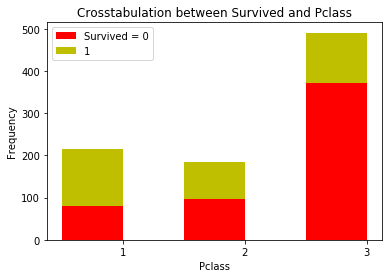

In [19]:
xtab_out = dtrain.crosstab(row = "Survived", col = "Pclass")
survived0=xtab_out["Crosstab"].loc[0][1:4]
survived1=xtab_out["Crosstab"].loc[1][1:4]
ind = np.arange(3)    # the x locations for the groups
width = 0.5       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, survived0, width, color='r')
p2 = plt.bar(ind, survived1, width, color='y', bottom=survived0)

plt.ylabel('Frequency')
plt.xlabel('Pclass')
plt.title('Crosstabulation between Survived and Pclass')
plt.xticks(ind + width/2., ('1', '2', '3'))
plt.legend((p1[0], p2[0]), ('Survived = 0', '1'), loc=2)

#### * Apparently, both Gender and Pclass are important variables regarding surival *

## Model Data Using Decision Tree

###  0. Do Feature Engineering

In [20]:
sasCode = 'if find(name, "master", 1, "it") then child =1;\n'
sasCode = sasCode + 'else if (not missing(age)) and (age <= 7) then child = 1;\n'
sasCode = sasCode + 'else child = 0;'
print(sasCode)
s.dataStep.runCode(code="data train_2; set train; "+sasCode+" run;")
#trainTbl2 = dtrain.datastep(sasCode,casout=dict(name='train_2', replace = True))
trainTbl2 = s.CASTable('train_2')
trainTbl2.columninfo()

if find(name, "master", 1, "it") then child =1;
else if (not missing(age)) and (age <= 7) then child = 1;
else child = 0;


,Column,ID,Type,RawLength,FormattedLength,NFL,NFD
0,PassengerId,1,double,8,12,0,0
1,Survived,2,double,8,12,0,0
2,Pclass,3,double,8,12,0,0
3,Name,4,varchar,82,82,0,0
4,Sex,5,varchar,6,6,0,0
5,Age,6,double,8,12,0,0
6,SibSp,7,double,8,12,0,0
7,Parch,8,double,8,12,0,0
8,Ticket,9,varchar,18,18,0,0
9,Fare,10,double,8,12,0,0


In [21]:
trainTbl2.fetch(to = 5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,child
0,1.0,0.0,3.0,"Braund, Mr. Owen Harris",male,22.0,1.0,0.0,A/5 21171,725.0,,S,0.0
1,2.0,1.0,1.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1.0,0.0,PC 17599,712833.0,C85,C,0.0
2,3.0,1.0,3.0,"Heikkinen, Miss. Laina",female,26.0,0.0,0.0,STON/O2. 3101282,7925.0,,S,0.0
3,4.0,1.0,1.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1.0,0.0,113803,531.0,C123,S,0.0
4,5.0,0.0,3.0,"Allen, Mr. William Henry",male,35.0,0.0,0.0,373450,805.0,,S,0.0


In [22]:
#testTbl = s.CASTable('test')
s.dataStep.runCode(code="data test_2; set test; "+sasCode+" run;")
#testTbl2 = testTbl.datastep(sasCode,casout=dict(name='test_2', replace = True))
testTbl2 = s.CASTable('test_2')
testTbl2.fetch(to = 5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,child
0,892.0,3.0,"Kelly, Mr. James",male,345.0,0.0,0.0,330911,78292.0,,Q,0.0
1,893.0,3.0,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1.0,0.0,363272,7.0,,S,0.0
2,894.0,2.0,"Myles, Mr. Thomas Francis",male,62.0,0.0,0.0,240276,96875.0,,Q,0.0
3,895.0,3.0,"Wirz, Mr. Albert",male,27.0,0.0,0.0,315154,86625.0,,S,0.0
4,896.0,3.0,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1.0,1.0,3101298,122875.0,,S,0.0


###  1. Partition data on-the-fly

In [23]:
## random number generation ##

trainTbl2.compvars = "__partID__"
trainTbl2.comppgm = "call streaminit(_rankid_*1000+_threadid_);__partID__=rand('UNIFORM');"

out1 = s.table.partition(table = trainTbl2, outTable = {'name':'dat1','replace':True})
dat1 = s.CASTable('dat1')

dat1.fetch(to=3)




,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,child,__partID__
0,1.0,0.0,3.0,"Braund, Mr. Owen Harris",male,22.0,1.0,0.0,A/5 21171,725.0,,S,0.0,0.883866
1,2.0,1.0,1.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1.0,0.0,PC 17599,712833.0,C85,C,0.0,0.973821
2,3.0,1.0,3.0,"Heikkinen, Miss. Laina",female,26.0,0.0,0.0,STON/O2. 3101282,7925.0,,S,0.0,0.507583


### 2. Generate a list of predicators

In [24]:
df1 = s.columninfo("train_2")["ColumnInfo"]
df1

,Column,ID,Type,RawLength,FormattedLength,NFL,NFD
0,PassengerId,1,double,8,12,0,0
1,Survived,2,double,8,12,0,0
2,Pclass,3,double,8,12,0,0
3,Name,4,varchar,82,82,0,0
4,Sex,5,varchar,6,6,0,0
5,Age,6,double,8,12,0,0
6,SibSp,7,double,8,12,0,0
7,Parch,8,double,8,12,0,0
8,Ticket,9,varchar,18,18,0,0
9,Fare,10,double,8,12,0,0


In [25]:
varlist = df1["Column"][(df1["Column"]!="Survived") & (df1["Column"]!="PassengerId") & 
                        (df1["Column"]!="Cabin") & (df1["Column"]!="Ticket")].tolist()
varlist

['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'child']

### 3. Decision Tree Model Training

In [26]:
print('Decision tree training for training dataset...')
start_time = time.clock()

trainprop = 0.6
dat1.where = "__partID__ LE %F" % trainprop # data partition -- select 60% of data randomly as training data
dat1.varlist = varlist
dtreeout = s.dtreetrain(
    table = dat1,                                  # input data#
    inputs = varlist,                              # list of all predictors
    nominal = ['Survived','Pclass','SibSp','Parch','Child'],
    casout = table(name='dt_model1',replace=True), # generated similarity table # 
    target = 'Survived',                           # target variable #
    nbins = 20, maxlevel = 6, leafsize = 10,       # tree options # 
    varimp=True
)
print("Training time is " + str(time.clock()-start_time) + "s")
dat1.where = ""   # reset where clause
dat1.varlist = [] # reset varlist for dat1
dtreeout


Decision tree training for training dataset...
Training time is 0.020000000000000018s


,Descr,Value
0,Anzahl der Baumknoten,33.000000
1,Max Anzahl der Verzweigungen,2.000000
2,Anzahl der Ebenen,6.000000
3,Anzahl Blätter,17.000000
4,Anzahl der Intervalle,20.000000
5,Minimum Größe der Blätter,10.000000
6,Maximum Größe der Blätter,132.000000
7,Anzahl Variablen,9.000000
8,Konfidenzniveau für Pruning,0.250000
9,Anzahl verwendete Beobachtungen,524.000000


*Both Pclass and sex are important based on the variable importance from the tree model to predict the survival rate. This also agrees with the previous simple crosstab results.*

### 4. Model Assessment

In [29]:
# first score the validation data
dat1.where = "__partID__ GT %F" % trainprop # data partition -- select 40% of data randomly as validation data
score_out = s.dtreescore(
    table = dat1,                                    # Table for scoring #
    casout = table(name='dt_score',replace=True),   # Table stores the scoring results #
    model  = 'dt_model1',                           # Decison tree model #
    copyVars = {"Survived"},
    target = 'Survived', 
    assess = True
)

dat1.where = ""   # reset where clause
dat1.varlist = [] # reset varlist for dat1
score_out

,casLib,Name,Rows,Columns,casTable
0,CASUSER(sasdemo),dt_score,734,15,"CASTable('dt_score', caslib='CASUSER(sasdemo)')"


In [30]:
dt_score = s.CASTable('dt_score')
dt_score.fetch(to = 5)

,Survived,_DT_PredName_,_DT_PredP_,_DT_PredLevel_,_LeafID_,_MissIt_,_NumNodes_,_NodeList0_,_NodeList1_,_NodeList2_,_NodeList3_,_NodeList4_,_NodeList5_,_DT_Level_,_DT_P_
0,0.0,0,0.878788,1.0,22.0,0.0,6.0,0.0,1.0,3.0,8.0,15.0,22.0,1,0.121212
1,0.0,0,0.878788,1.0,22.0,0.0,6.0,0.0,1.0,3.0,8.0,15.0,22.0,0,0.878788
2,1.0,1,1.000000,0.0,11.0,0.0,4.0,0.0,2.0,5.0,11.0,NaN,NaN,1,1.000000
3,1.0,1,1.000000,0.0,11.0,0.0,4.0,0.0,2.0,5.0,11.0,NaN,NaN,0,0.000000
4,1.0,1,0.978723,0.0,25.0,0.0,6.0,0.0,2.0,5.0,12.0,17.0,25.0,1,0.978723


In [48]:
#second, LIFT and ROC
s.builtins.loadActionSet("percentile")


dt_score.computedVars=["P1", "P0"] # 3
dt_score.computedVarsProgram='''
    if '1' eq strip(_DT_PredName_) then do;
        P1 = _DT_PredP_;
        P0 = 1 - _DT_PredP_;
    end;
    else do;
        P1 = 1 - _DT_PredP_;
        P0 = _DT_PredP_;
    end;
'''

dt_score.percentile.assess(
    casOut={"name":"assess", "replace":True},
    nbins=10,
    cutStep = 0.01,
    inputs=['P1'],
    response='survived',
    event='1',
    pVar=['P0'],
    pEvent='0'
)

assess = s.CASTable('assess')
assess_ROC = s.CASTable("assess_ROC")

NOTE: Added action set 'percentile'.


In [49]:
assess.columninfo()

,Column,ID,Type,RawLength,FormattedLength,Format,NFL,NFD
0,_Column_,1,char,2,2,$,2,0
1,_Event_,2,char,12,12,$,12,0
2,_Depth_,3,double,8,12,BEST,12,0
3,_Value_,4,double,8,12,BEST,12,0
4,_NObs_,5,double,8,12,BEST,12,0
5,_NEvents_,6,double,8,12,BEST,12,0
6,_NEventsBest_,7,double,8,12,BEST,12,0
7,_Resp_,8,double,8,12,BEST,12,0
8,_RespBest_,9,double,8,12,BEST,12,0
9,_Lift_,10,double,8,12,BEST,12,0


In [50]:
assess_ROC.columninfo()

,Column,ID,Type,RawLength,FormattedLength,Format,NFL,NFD
0,_Column_,1,char,2,2,$,2,0
1,_Event_,2,char,12,12,$,12,0
2,_Cutoff_,3,double,8,12,BEST,12,0
3,_TP_,4,double,8,12,BEST,12,0
4,_FP_,5,double,8,12,BEST,12,0
5,_FN_,6,double,8,12,BEST,12,0
6,_TN_,7,double,8,12,BEST,12,0
7,_Sensitivity_,8,double,8,12,BEST,12,0
8,_Specificity_,9,double,8,12,BEST,12,0
9,_KS_,10,double,8,12,BEST,12,0


### ROC curve

In [52]:
assess_roc = assess_ROC[["_Specificity_","_Sensitivity_"]]
assess_roc.fetch(to=3)

,_Specificity_,_Sensitivity_
0,0.000000,1.000000
1,0.013636,0.972789
2,0.013636,0.972789


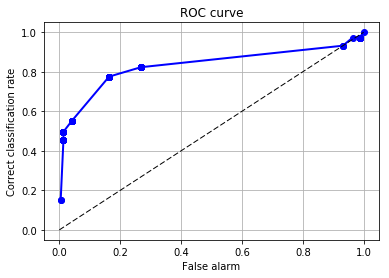

In [53]:
out2 = assess_ROC.to_frame()

plt.plot(1-out2._Specificity_,out2._Sensitivity_,'bo-',linewidth=2)
plt.plot(pd.Series(range(0,11,1))/10,pd.Series(range(0,11,1))/10,'k--',linewidth=1)
#plt.plot(1-out2._Specificity_,1-out2._Specificity_,'k*-',linewidth=2)
plt.xlabel('False alarm')
plt.ylabel('Correct classification rate')
plt.grid(True)
plt.title('ROC curve')
plt.show()

### LIFT chart

In [54]:
out_lift = assess[["_column_", "_depth_","_Cumlift_","_CumliftBest_"]]
out_lift.fetch(to=3)

,_Column_,_Depth_,_CumLift_,_CumLiftBest_
0,P1,10.0,2.408453,2.517007
1,P1,20.0,2.414966,2.517007
2,P1,30.0,2.098639,2.517007


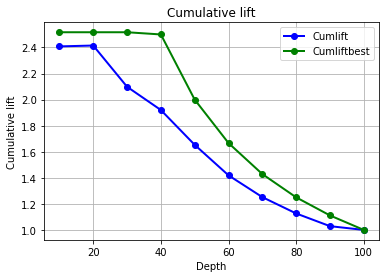

In [56]:
out3 = out_lift.to_frame()

plt.plot(out3._Depth_,out3._CumLift_,'bo-',linewidth=2,label='Cumlift')
plt.plot(out3._Depth_,out3._CumLiftBest_,'go-',linewidth=2,label='Cumliftbest')

plt.xlabel('Depth')
plt.ylabel('Cumulative lift')

plt.grid(True)
plt.title('Cumulative lift')
plt.legend(loc='best', numpoints=1)
plt.show()

## Deploy Model

In [60]:
s.dtreescore(
    table (
        name= 'test_2'
    ),                                              # Table for scoring #
    casout = table(name='dt_score_test',replace=True),   # Table stores the scoring results #
    model  = 'dt_model1',                           # Decison tree model #
    #idvarList = 'PassengerId'                       # Bring the passenger id to the scored results
)

,casLib,Name,Rows,Columns,casTable
0,CASUSER(sasdemo),dt_score_test,418,12,"CASTable('dt_score_test', caslib='CASUSER(sasd..."


In [61]:
stab = s.CASTable('dt_score_test')
stab.head(n=5)

,_DT_PredName_,_DT_PredP_,_DT_PredLevel_,_LeafID_,_MissIt_,_NumNodes_,_NodeList0_,_NodeList1_,_NodeList2_,_NodeList3_,_NodeList4_,_NodeList5_
0,0,0.940171,1.0,21.0,NaN,6.0,0.0,1.0,3.0,8.0,15.0,21.0
1,0,1.000000,1.0,13.0,NaN,4.0,0.0,2.0,6.0,13.0,NaN,NaN
2,0,0.878788,1.0,22.0,NaN,6.0,0.0,1.0,3.0,8.0,15.0,22.0
3,0,0.878788,1.0,22.0,NaN,6.0,0.0,1.0,3.0,8.0,15.0,22.0
4,0,0.515152,1.0,32.0,NaN,6.0,0.0,2.0,6.0,14.0,20.0,32.0


In [77]:
#stab.freq()
s.freq(table(name='dt_score_test',vars='_dt_predname_')) # how the model predicts (0: not survived 1: survived)

,Column,CharVar,FmtVar,Level,Frequency
0,_DT_PredName_,0,0,1,306.0
1,_DT_PredName_,1,1,2,112.0


In [78]:
s.endsession

?.session.Endsession()